In [1]:
import os, json, gc, re, sys, warnings, textwrap
from datetime import datetime, date
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chunksize = 100_000
reader = pd.read_json('/Users/vidur/Desktop/DSM/DSM_FinalProject/data/Yelp JSON/yelp_dataset/yelp_academic_dataset_checkin.json', lines=True, chunksize=chunksize)
sample = next(reader)

print("Checkin Sample (first 10 rows):")
print(sample.head(10))


print("Missing business_id:", sample['business_id'].isna().sum())
print("Missing date:", sample['date'].isna().sum())

sample['num_checkins'] = sample['date'].str.count(',') + 1
print("\nCheckins per business (sample) stats:")
print(sample['num_checkins'].describe())

print("\nData types:")
print(sample.dtypes)

Checkin Sample (first 10 rows):
              business_id                                               date
0  ---kPU91CF4Lq2-WlRu9Lw  2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...
1  --0iUa4sNDFiZFrAdIWhZQ  2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...
2  --30_8IhuyMHbSOcNWd6DQ           2013-06-14 23:29:17, 2014-08-13 23:20:22
3  --7PUidqRWpRSpXebiyxTg  2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...
4  --7jw19RH9JKXgFohspgQw  2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...
5  --8IbOsAAxjKRoYsBFL-PA  2015-06-06 01:03:19, 2015-07-29 16:50:58, 2015...
6  --9osgUCSDUWUkoTLdvYhQ  2015-06-13 02:00:57, 2015-07-04 00:44:09, 2015...
7  --ARBQr1WMsTWiwOKOj-FQ  2014-12-12 00:44:23, 2015-01-09 00:19:52, 2015...
8  --FWWsIwxRwuw9vIMImcQg  2010-09-11 16:28:39, 2010-12-22 21:14:19, 2011...
9  --FcbSxK1AoEtEAxOgBaCw  2017-08-18 19:43:50, 2017-10-07 22:38:38, 2017...
Missing business_id: 0
Missing date: 0

Checkins per business (sample) stats:
count    100000.000000
mean        102.4436

In [3]:
RAW_PATH      = "/Users/vidur/Desktop/DSM/DSM_FinalProject/data/Yelp JSON/yelp_dataset/yelp_academic_dataset_checkin.json" 
PARQUET_PATH  = "/Users/vidur/Desktop/DSM/DSM_FinalProject/data/checkin_clean.parquet"
BAD_ROWS_LOG  = "checkin_parse_errors.csv"

CHUNKSIZE = 500_000         
DATE_RANGE = ("2004-01-01", pd.Timestamp.today().normalize())

# 1‑liner for stripping left/right whitespace on every comma‑separated token
def clean_date_string(s: str) -> str:
    return re.sub(r"\s*,\s*", ",", s.strip()) if isinstance(s, str) else ""

def explode_checkins(df_chunk: pd.DataFrame) -> pd.DataFrame:
    """Split the comma‑separated timestamp list into one row per check‑in."""
    df_chunk["date"] = df_chunk["date"].apply(clean_date_string)
    exploded = df_chunk.assign(
        timestamp_str = df_chunk["date"].str.split(",")
    ).explode("timestamp_str").drop(columns="date")
    exploded["timestamp_str"] = exploded["timestamp_str"].str.strip()
    return exploded


In [4]:
stats = {
    "rows_read"       : 0,
    "rows_exploded"   : 0,
    "null_business_id": 0,
    "null_timestamp"  : 0,
    "parse_fail"      : 0
}

# Prepare output holders
clean_batches   = []      # arrow Tables get appended and written once for speed
error_records   = []      # rows we couldn't parse

reader = pd.read_json(RAW_PATH, lines=True, chunksize=CHUNKSIZE)

for chunk in tqdm(reader, desc="Processing chunks"):
    stats["rows_read"] += len(chunk)
    
    # --- basic null handling -------------------------------------------------
    stats["null_business_id"] += chunk["business_id"].isna().sum()
    stats["null_timestamp"]   += chunk["date"].isna().sum()
    chunk = chunk.dropna(subset=["business_id", "date"])
    
    # --- explode comma‑separated lists --------------------------------------
    exploded = explode_checkins(chunk)
    stats["rows_exploded"] += len(exploded)
    
    # --- parse timestamps safely --------------------------------------------
    exploded["timestamp"] = pd.to_datetime(
        exploded["timestamp_str"], errors="coerce", format="%Y-%m-%d %H:%M:%S"
    )
    bad_mask = exploded["timestamp"].isna()
    if bad_mask.any():
        stats["parse_fail"] += bad_mask.sum()
        error_records.append(exploded.loc[bad_mask, ["business_id", "timestamp_str"]])
        exploded = exploded.loc[~bad_mask]

    # --- date‑range sanity filter -------------------------------------------
    exploded = exploded.loc[
        (exploded["timestamp"] >= DATE_RANGE[0]) &
        (exploded["timestamp"] <= DATE_RANGE[1])
    ]

    # --- feature engineering -------------------------------------------------
    exploded["date_only"]   = exploded["timestamp"].dt.date
    exploded["hour"]        = exploded["timestamp"].dt.hour
    exploded["dayofweek"]   = exploded["timestamp"].dt.dayofweek   # 0 = Mon
    exploded["year_month"]  = exploded["timestamp"].dt.to_period("M")

    clean_batches.append(exploded.astype({
        "business_id": "category",
        "hour"       : "int8",
        "dayofweek"  : "int8"
    }))
    
    # free RAM
    del chunk, exploded
    gc.collect()

# ---------------------------------------------------------------------------
# concatenate & write once to avoid many tiny parquet files
clean_df = pd.concat(clean_batches, ignore_index=True)
clean_df.to_parquet(PARQUET_PATH, index=False, compression="snappy")

# log parse errors if any
if error_records:
    pd.concat(error_records).to_csv(BAD_ROWS_LOG, index=False)

print("✅ Cleaning complete\n", json.dumps(stats, indent=2, default=str))
print(f"Clean parquet saved to: {PARQUET_PATH}")


Processing chunks: 1it [00:12, 12.67s/it]


✅ Cleaning complete
 {
  "rows_read": 131930,
  "rows_exploded": 13356875,
  "null_business_id": "0",
  "null_timestamp": "0",
  "parse_fail": 0
}
Clean parquet saved to: /Users/vidur/Desktop/DSM/DSM_FinalProject/data/checkin_clean.parquet


In [5]:
df = pd.read_parquet(PARQUET_PATH)
print(df.shape)
df.head()


(13356875, 7)


,business_id,timestamp_str,timestamp,date_only,hour,dayofweek,year_month
0,---kPU91CF4Lq2-WlRu9Lw,2020-03-13 21:10:56,2020-03-13 21:10:56,2020-03-13,21,4,2020-03
1,---kPU91CF4Lq2-WlRu9Lw,2020-06-02 22:18:06,2020-06-02 22:18:06,2020-06-02,22,1,2020-06
2,---kPU91CF4Lq2-WlRu9Lw,2020-07-24 22:42:27,2020-07-24 22:42:27,2020-07-24,22,4,2020-07
3,---kPU91CF4Lq2-WlRu9Lw,2020-10-24 21:36:13,2020-10-24 21:36:13,2020-10-24,21,5,2020-10
4,---kPU91CF4Lq2-WlRu9Lw,2020-12-09 21:23:33,2020-12-09 21:23:33,2020-12-09,21,2,2020-12


count    131930.000000
mean        101.242136
std         417.132327
min           1.000000
25%           6.000000
50%          20.000000
75%          72.000000
90%         229.000000
99%        1282.000000
max       52144.000000
dtype: float64


/var/folders/b3/b3lpk8w51qj10znm_7bkftgr0000gn/T/ipykernel_43670/1954071084.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chk_per_biz = df.groupby("business_id").size()


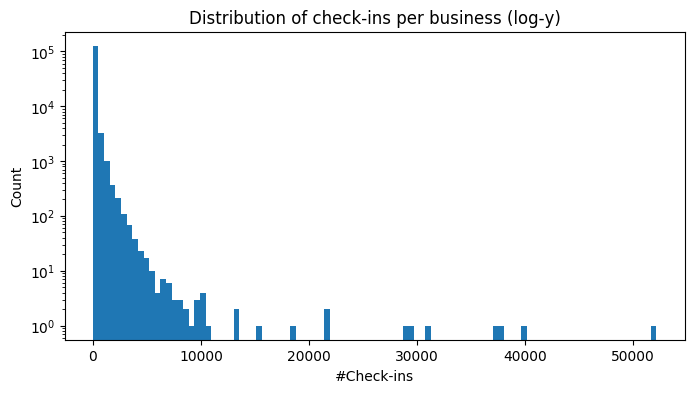

In [6]:
# Check‑ins per business
chk_per_biz = df.groupby("business_id").size()
print(chk_per_biz.describe(percentiles=[.25,.5,.75,.9,.99]))

# Histogram (log‑x for heavy tail)
plt.figure(figsize=(8,4))
plt.hist(chk_per_biz, bins=100, log=True)
plt.title("Distribution of check‑ins per business (log‑y)"); plt.xlabel("#Check‑ins"); plt.ylabel("Count")
plt.show()

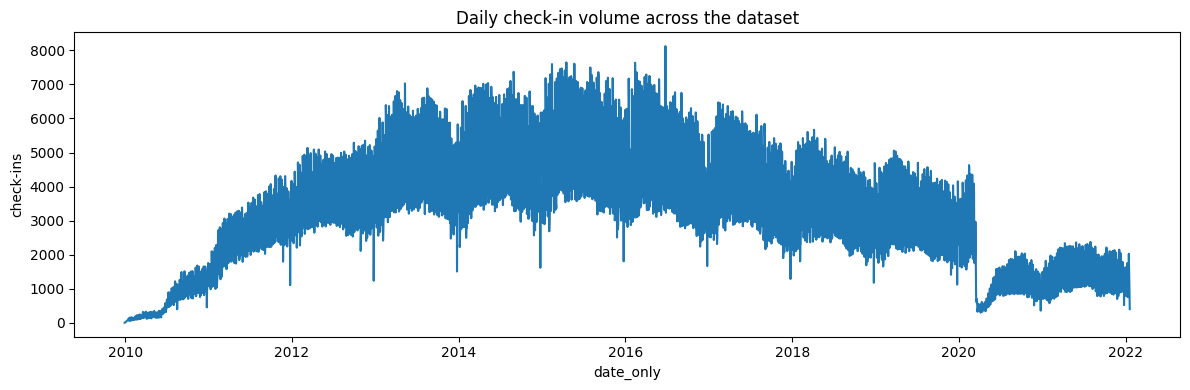

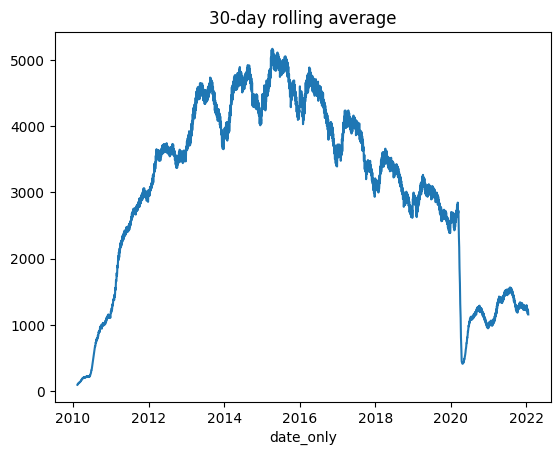

In [7]:
daily = df.groupby("date_only").size()

plt.figure(figsize=(12,4))
daily.plot()
plt.title("Daily check‑in volume across the dataset")
plt.ylabel("check‑ins")
plt.tight_layout()
plt.show()

# Rolling 30‑day mean to smooth
daily.rolling(30).mean().plot(title="30‑day rolling average")
plt.show()


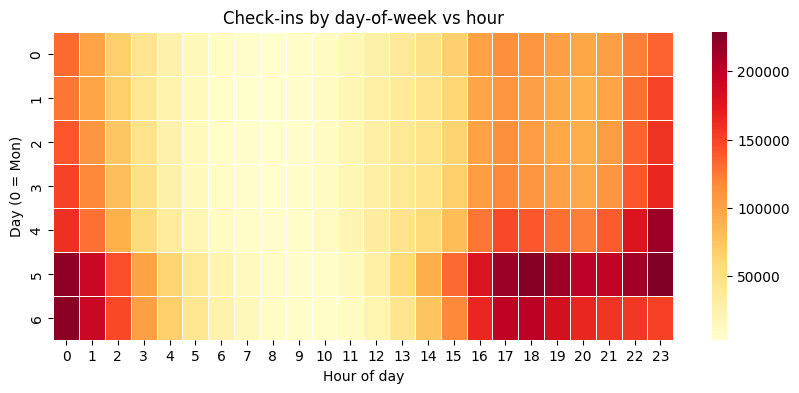

In [8]:
heat = (
    df.groupby(["dayofweek","hour"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=[0,1,2,3,4,5,6])       # to keep Mon‑Sun order
)
plt.figure(figsize=(10,4))
sns.heatmap(heat, cmap="YlOrRd", linewidths=.5)
plt.title("Check‑ins by day‑of‑week vs hour")
plt.xlabel("Hour of day"); plt.ylabel("Day (0 = Mon)")
plt.show()


In [9]:
# 3‑sigma on log scale
log_counts = np.log1p(chk_per_biz)
high_cut   = log_counts.mean() + 3*log_counts.std()
outliers   = chk_per_biz[log_counts > high_cut]
print(f"Businesses with abnormally high check‑ins (>3σ): {len(outliers)}")


Businesses with abnormally high check‑ins (>3σ): 216


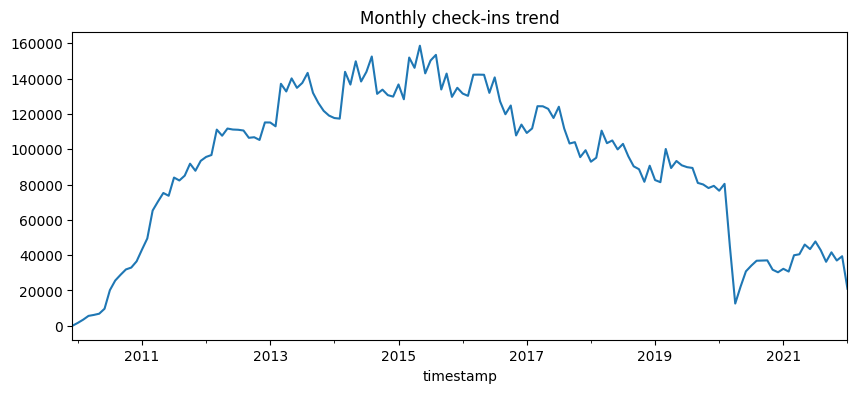

In [10]:
monthly = df.groupby(df["timestamp"].dt.to_period("M")).size()
monthly.index = monthly.index.to_timestamp()
monthly.plot(title="Monthly check‑ins trend", figsize=(10,4))
plt.show()
